# Interactive hypothesis testing

If you need to test a hypothesis interactively along multiple dimensions or their combinations, we are showing below an example demonstrating how this can be achieved with [atoti](https://docs.atoti.io).

# Imports

In [1]:
import numpy as np
from scipy.stats import norm, t
import pandas as pd
from IPython.display import display

In [2]:
import atoti as tt

Welcome to atoti 0.4.2.20200617181308!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Raw data

In [3]:
# Example data is taken from kaggle user submission:
# https://www.kaggle.com/steveahn/memory-test-on-drugged-islanders-data
df = pd.read_csv("Islander_data.csv")
df = df.reset_index()
# FIXME: joining critical values store using an artificial key:
df['Experiment'] = "Experiment"

In [4]:
# Vectorizing before and after measurements for convenience
df['MemoryScoresVector'] = df['Mem_Score_Before'].astype(str) + ";" + df['Mem_Score_After'].astype(str)

In [5]:
df = df[['index', 'first_name', 'last_name', 'age', 'Happy_Sad_group', 'Dosage',
       'Drug', 'Diff', 'MemoryScoresVector', "Experiment"]]

## Launching atoti app

In [6]:
session = tt.create_session()
observations_datastore = session.read_pandas(
    df, keys=["index"], array_sep = ";", store_name="Observations"
)
cube = session.create_cube(observations_datastore)

h = cube.hierarchies
l = cube.levels
m = cube.measures

## URL of atoti app

The following cell displays URL of atoti app:

In [7]:
session.url

'http://localhost:60059'

# Inline data visualization

By running the next cell, we embed an data visualization widget - slice and dice in the notebook.

In [9]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Adding a custom grouping - age groups

I want to group obvervations by age. To achieve that, I'm creating and uploading **age to group mapping** into a separate data store:

In [10]:
age_groups_store = session.read_pandas(
    pd.DataFrame(
        data=[("0-25Y", i) for i in range(25)]
        + [("25Y - 50Y", i) for i in range(25, 50)]
        + [("50Y+", i) for i in range(50, 100)],
        columns=["age group", "age"],
    ),
    keys=["age"],
    store_name="Age Groups",
)

observations_datastore.join(age_groups_store)

We will start using this grouping in one of the following cells.

# "Before and After" dimension

I have loaded the before and after measurements in vectorized format: (before, after), and now I want to access the first and the second elements using a "Before and After" hierarchy. The following cell is creating it:

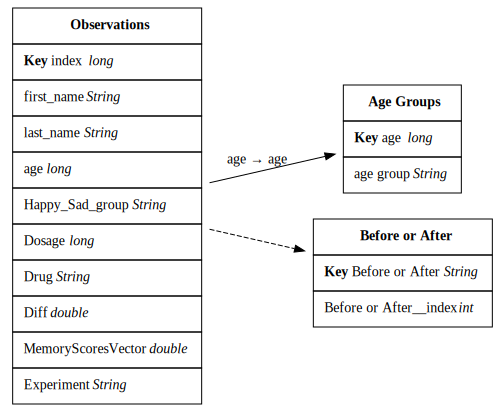

In [11]:
cube.create_parameter_hierarchy(
    "Before or After", ["Before", "After"], index_measure="Before After Index"
)

# Setting the Before and After to slicing to switch off
# the aggregation between before and after measurements
h["Before or After"].slicing = True

# Sorting the hierarchy, so that the Before measurements show first:
l["Before or After"].comparator = tt.comparator.DESC

# Hiding the vector from the user interface:
m["MemoryScoresVector.MEAN"].visible = False

# The new parameter hierarchy is visible in the cube schema:
display(cube.schema)

# This measure will display Memory Scores for the "Before" and "After" measurements:
m['MemoryScores'] = m['MemoryScoresVector.MEAN'][m['Before After Index']]

From the following visualization we can tell, that on average:
-    for the Drug **"T"** memory scores **did not increase** in all age groups,
-    for the Drug **"A"** memory scores **increased in both age groups**, with a bigger impact in group 25Y-50Y,
-    for the Drug **"S"** the scores **fluctuated**, they slighly decreased and slighly increased in groups 25Y-50Y and 50Y+ accordingly.

In [13]:
cube.visualize("Average memory score by drug")

Install and enable the atoti JupyterLab extension to see this widget.

# Slice-and-dice basic statistics

In [14]:
m['Mean'] = tt.agg.mean(m['MemoryScores'], scope = tt.scope.origin(l['index']))
m['Mean'] = tt.agg.mean(m['MemoryScores'], scope = tt.scope.origin(l['index']))
m['Std'] = tt.agg.std(m['MemoryScores'], scope = tt.scope.origin(l['index']))
m['Min'] = tt.agg.min(m['MemoryScores'], scope = tt.scope.origin(l['index']))
m['Max'] = tt.agg.max(m['MemoryScores'], scope = tt.scope.origin(l['index']))
m['25%'] =  tt.agg.quantile(m['MemoryScores'], 0.25, scope = tt.scope.origin(l['index']))
m['50%'] =  tt.agg.quantile(m['MemoryScores'], 0.50, scope = tt.scope.origin(l['index']))
m['75%'] =  tt.agg.quantile(m['MemoryScores'], 0.75, scope = tt.scope.origin(l['index']))

We can now slice-and-dice those statistics using any attribute available in the data.

This is an example, where the Happy or Sad field has been put onto the columns. Every time I bring an additional attribute into the view, the statistics - such averages, standard deviation and quantiles - are recomputed from the raw data.

In [16]:
cube.visualize("Basic statistics slice-and-dice")

Install and enable the atoti JupyterLab extension to see this widget.

# Interactive Z confidence interval

In [17]:
alpha = 0.05

m['95% point'] = norm.ppf(1 - alpha / 2.)
m['Z confidence left'] = m['Mean'] - m['95% point'] * m['Std']
m['Z confidence right'] = m['Mean'] + m['95% point'] * m['Std']

We have just created the metrics to visualize confidence intervals interactively.

In [19]:
cube.visualize("Interactive confidence intervals")

Install and enable the atoti JupyterLab extension to see this widget.

# Refining the application

In [21]:
# This cell is hiding undesired default metrics.
# To create a cube without any default metrics, create_cube need to be used with parameter mode = `no_measures`
m['MemoryScoresVector.SUM'].visible = False
m['Diff.SUM'].visible = False

# Paired t-test

Let's see how a paired t-test can be applied in atoti.

A [paired t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Paired_samples) is a classical routine that can help testing a medication efficacy, given the before and after measurements. We will check that the data provides evidence that will allow us to reject the null hypothesis:

- H0: on average, there's no difference in observations before and after, $\mu_{diff}=0$
- H1: on average, the score after is bigger than before, $\mu_{diff}>0$

To compute the t-statistic, we'd need mean, stdev and the number of observations. We do have a measure for mean - `Diff.MEAN` - and a measure for the number of observations - `contributors.COUNT`. Let's compute stdev.

In [26]:
# Measure displaying individual differences:
m['Diff'] = tt.agg.single_value(observations_datastore['Diff'])

In [27]:
# Computing standard deviation of differences.
m['Diff.Std'] = tt.agg.std(m['Diff'], scope = tt.scope.origin(l['index']))

In [28]:
m['t-statistic'] = m['Diff.MEAN']/(m['Diff.Std']/tt.sqrt(m['contributors.COUNT']))

We will be comparing the `t-statistic` to the right tail _critical value_, and if it's above the critical value, we will conclude that the data provides the evidence to reject the null hypothesis. Let's load 95% critical value into the cube.

In [ ]:
# FIXME: tried tt.at to pick critical value 

# critical_values_datastore = session.read_pandas(
#     pd.DataFrame(
#         data={
#             "Experiment": ["Experiment"]*df.shape[0],
#             "Degrees of freedom": [d for d in range(1, df.shape[0] + 1)],
#             "critical value": [t.ppf(0.95, d) for d in range(1, df.shape[0] + 1)]
#         }
#     ),
#     store_name="CriticalValues",
# #     types = {"Degrees of freedom": tt.types.STRING},
#     #     types = {"Degrees of freedom": tt.types.STRING},
#     keys=["Experiment", "Degrees of freedom"]
# )

# observations_datastore.join(critical_values_datastore, mapping = {"Experiment": "Experiment"})

# h['Degrees of freedom'].slicing = True
# m['test'] = tt.at(m['critical value.VALUE'], {l['Degrees of freedom']: 2})

In [29]:
t_critical_values_datastore = session.read_pandas(
    pd.DataFrame(
        data={
            "Experiment": ["Experiment"],
            "t-critical vector": ";".join(["{:.3f}".format(t.ppf(0.95, d)) for d in range(1, df.shape[0] + 1)])
        }
    ),
    store_name="TCriticalValues",
    keys=["Experiment"],
    array_sep=";",
)
t_critical_values_datastore.head(3)

,t-critical vector
Experiment,
Experiment,"doubleVector[198]{6.314, ...}"


In [30]:
observations_datastore.join(t_critical_values_datastore, mapping = {"Experiment": "Experiment"})

Now, depending on the number of observations for each cell, we can pick a critical value using the following syntax:

In [31]:
# FIXME: m['T Critical Value'] = m['t-critical vector.VALUE'][tt.round(m['contributors.COUNT'])]
# - giving this exception: UnsupportedOperationException: Cannot read 'int' value from an instance of ArrayChunkLongNullable
m["t-critical value"] = m["t-critical vector.VALUE"][50]

In [32]:
# FIXME: m['Test Result'] = tt.where(m["t-statistic"]>=m['T Critical Value'], "H0 rejected", "Can't reject H0")
# - returns nothing.
m["Test Result"] = m["t-statistic"] > m["t-critical value"]

The `Test Result` metric is visualizing the result of t-test every time we expand and collapse data.

In [34]:
cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

# Seaborn charts for distribution analysis

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

,index,Drug,Diff.MEAN
0,0,A,-2.3
1,1,A,-0.9
2,2,A,-4.6


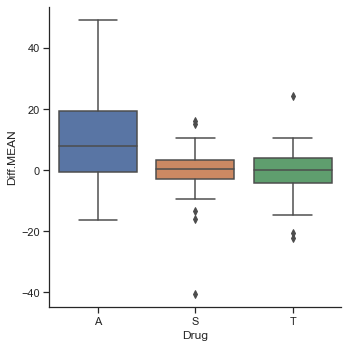

In [38]:
# Boxplot - memory score effect by drug
d = cube.query(m['Diff.MEAN'], levels = [l['index'], l['Drug']]).reset_index()
display(d.head(3))
sns.catplot(x="Drug", y="Diff.MEAN", kind="box", data=d);

,index,Drug,Happy_Sad_group,Diff.MEAN
0,0,A,H,-2.3
1,1,A,S,-0.9
2,2,A,H,-4.6


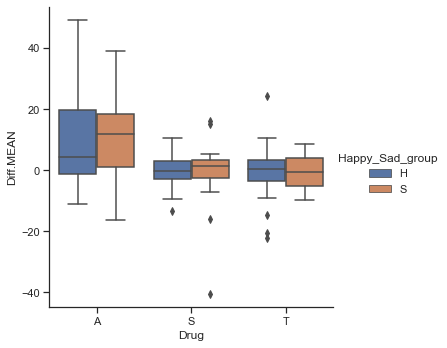

In [39]:
# Boxplot - memory score effect by drug and Happy_Sad_group
d = cube.query(m['Diff.MEAN'], levels = [l['index'], l['Drug'], l['Happy_Sad_group']]).reset_index()
display(d.head(3))
sns.catplot(x="Drug", y="Diff.MEAN", hue = "Happy_Sad_group", kind="box", data=d);

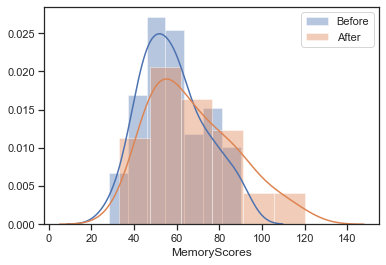

In [40]:
# Drug A before and after empirical distribution histogram

sns.distplot(
    cube.query(
        m["MemoryScores"],
        levels=[l["index"]],
        condition=(l["Drug"] == "A") & (l["Before or After"] == "Before"),
    )["MemoryScores"],
    label="Before",
)
sns.distplot(
    cube.query(
        m["MemoryScores"],
        levels=[l["index"]],
        condition=(l["Drug"] == "A") & (l["Before or After"] == "After"),
    )["MemoryScores"],
    label="After",
)
plt.legend()